In [ ]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import (
    InverseKinematics,
    AddMultibodyPlantSceneGraph,
    BsplineTrajectory,
    DiagramBuilder,
    KinematicTrajectoryOptimization,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MinimumDistanceLowerBoundConstraint,
    LogVectorOutput,
    Parser,
    PositionConstraint,
    Rgba,
    ConstantVectorSource,
    RigidTransform,
    Role,
    Solve,
    Sphere,
    StartMeshcat,
    TrajectorySource,
    Simulator,
    RotationMatrix,
    PiecewisePose,
)

from pydrake.common import temp_directory
from pydrake.trajectories import PiecewisePolynomial
from manipulation.station import MakeHardwareStation, load_scenario
from manipulation import running_as_notebook
from manipulation.meshcat_utils import PublishPositionTrajectory
from manipulation.scenarios import AddIiwa, AddPlanarIiwa, AddShape, AddWsg
from manipulation.utils import ConfigureParser

In [ ]:
import numpy as np
from pydrake.all import (
    ConstantVectorSource,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
)
from pydrake.multibody import inverse_kinematics
from pydrake.trajectories import PiecewisePolynomial

from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import AddMultibodyTriad, MakeManipulationStation
from manipulation.utils import running_as_notebook

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://118e769b-4a3a-40aa-8d8d-69e00b8c0bfd.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


In [ ]:
with open("/work/box.sdf", "r") as box_sdf_file:
    box_sdf = box_sdf_file.read()

with open("/work/Carafe_with_stopper.sdf", "r") as bottle_sdf_file:
    bottle_sdf = bottle_sdf_file.read()

with open("/work/table.sdf", "r") as table_sdf_file:
    table_sdf = table_sdf_file.read()

with open("/work/scenario-can.txt", "r") as scenario_data_file:
    scenario = load_scenario(data=scenario_data_file.read())

In [ ]:
def create_q_knots(pose_lst):
    """Convert end-effector pose list to joint position list using series of
    InverseKinematics problems. Note that q is 9-dimensional because the last 2 dimensions
    contain gripper joints, but these should not matter to the constraints.
    @param: pose_lst (python list): post_lst[i] contains keyframe X_WG at index i.
    @return: q_knots (python_list): q_knots[i] contains IK solution that will give f(q_knots[i]) \approx pose_lst[i].
    """

    controller_builder = DiagramBuilder()
    plant, _ = AddMultibodyPlantSceneGraph(controller_builder, time_step=0.0001)
    controller_iiwa = AddIiwa(plant)
    controller_wsg = AddWsg(plant, controller_iiwa, roll=0.0, welded=True, sphere=True)

    plant.Finalize()

    q_knots = []
    world_frame = plant.world_frame()
    gripper_frame = plant.GetFrameByName("body")
    q_nominal = np.array(
        [0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0]
    )  # nominal joint angles for joint-centering.

    def AddOrientationConstraint(ik, R_WG, bounds):
        """Add orientation constraint to the ik problem. Implements an inequality
        constraint where the axis-angle difference between f_R(q) and R_WG must be
        within bounds. Can be translated to:
        ik.prog().AddBoundingBoxConstraint(angle_diff(f_R(q), R_WG), -bounds, bounds)
        """
        ik.AddOrientationConstraint(
            frameAbar=world_frame,
            R_AbarA=R_WG,
            frameBbar=gripper_frame,
            R_BbarB=RotationMatrix(),
            theta_bound=bounds,
        )

    def AddPositionConstraint(ik, p_WG_lower, p_WG_upper):
        """Add position constraint to the ik problem. Implements an inequality
        constraint where f_p(q) must lie between p_WG_lower and p_WG_upper. Can be
        translated to
        ik.prog().AddBoundingBoxConstraint(f_p(q), p_WG_lower, p_WG_upper)
        """
        ik.AddPositionConstraint(
            frameA=world_frame,
            frameB=gripper_frame,
            p_BQ=np.zeros(3),
            p_AQ_lower=p_WG_lower,
            p_AQ_upper=p_WG_upper,
        )

    initial_guess = q_nominal

    for i in range(len(pose_lst)):
        ik = inverse_kinematics.InverseKinematics(plant)
        q_variables = ik.q()  # Get variables for MathematicalProgram
        prog = ik.prog()  # Get MathematicalProgram

        #### Modify here ###############################

        AddOrientationConstraint(ik, pose_lst[i].rotation(), 0)
        d = 0.02

        AddPositionConstraint(ik, pose_lst[i].translation() - [d, 0, d], pose_lst[i].translation() + [d, 0, d])

        prog.AddCost((q_variables - q_nominal).dot(q_variables - q_nominal))

        prog.SetInitialGuess(ik.q(), initial_guess)

        ################################################

        result = Solve(prog)

        assert result.is_success()

        initial_guess = result.GetSolution(q_variables)

        q_knots.append(result.GetSolution(q_variables))

    return q_knots



In [ ]:
def create_trajectory(end_angle, end_rot_velocity):
    def create_pose_lst(time_to_throw):

        times = [0, 2, 3, 6, 6 + time_to_throw, 6 + 0.4]

        r = RotationMatrix.MakeXRotation(-np.pi / 2)

        small_rot = RigidTransform(RotationMatrix.MakeZRotation(np.pi / 8.0))
        x_rot = RigidTransform(RotationMatrix.MakeZRotation(end_angle))

        y_rot = RotationMatrix.MakeYRotation(np.pi / 2)
        z_rot = RotationMatrix.MakeZRotation(np.pi / 2)

        rot = RotationMatrix([
            [-1, 0, 0],
            [0, 0, -1],
            [0, -1, 0],
        ])

        frames = [RigidTransform(rot, [0.65, 0, 0.25]), RigidTransform(rot, [0.65, 0, 0.2]), RigidTransform(rot, [0.65, 0, 0.2]), RigidTransform(rot, [0.65, 0, 0.55]), RigidTransform(rot, [0.65, 0, 0.55]) @ x_rot, RigidTransform(rot, [0.45, 0, 0.55])]

        #frames.append(RigidTransform(frames[-1].rotation(), np.array([-0.1, 0, 0]) + frames[-1].translation()))

        return times, frames
    
    time_to_throw = 2 * end_angle / end_rot_velocity
    print (time_to_throw)
    times, frames = create_pose_lst(time_to_throw)

    q_knots = np.array(create_q_knots(frames))
    q_traj = PiecewisePolynomial.CubicShapePreserving(times, q_knots[:, 0:7].T)

    g_knots = np.array([0.1, 0.1, 0, 0, 0.1, 0.1])
    gripper_knots = g_knots.reshape(1, g_knots.shape[0])

    gripper_t_lst = [0, 2.2, 2.6, 6 + time_to_throw - 0.01, 6 + time_to_throw, 12]
    g_traj = PiecewisePolynomial.ZeroOrderHold(gripper_t_lst, gripper_knots)

    return q_traj, g_traj

In [ ]:
time_to_throw = 0.2
def create_trajectory(end_angle, end_rot_velocity, object_sdf_file):
    def create_pose_lst(time_to_throw):

        times = [0, 2, 3, 6, 6 + time_to_throw, 6 + time_to_throw + 0.2]

        r = RotationMatrix.MakeXRotation(-np.pi / 2)

        small_rot = RigidTransform(RotationMatrix.MakeZRotation(np.pi / 8.0))
        x_rot = RigidTransform(RotationMatrix.MakeZRotation(end_angle))

        y_rot = RotationMatrix.MakeYRotation(np.pi / 2)
        z_rot = RotationMatrix.MakeZRotation(np.pi / 2)

        rot = RotationMatrix([
            [-1, 0, 0],
            [0, 0, -1],
            [0, -1, 0],
        ])

        #height = get_height(box_sdf)
        height = 0.1
        print (height)

        #frames = [RigidTransform(rot, [0.65, 0, 0.25]), RigidTransform(rot, [0.65, 0, height - 0.01]), RigidTransform(rot, [0.65, 0, height + 0.01]), RigidTransform(rot, [0.65, 0, 0.55]), RigidTransform(rot, [0.65, 0, 0.55]) @ x_rot, RigidTransform(rot, [0.35, 0, 0.55])]
        frames = [RigidTransform(rot, [0.635, 0, 0.25]), RigidTransform(rot, [0.635, 0, height - 0.01]), RigidTransform(rot, [0.635, 0, height + 0.02]), RigidTransform(rot, [0.65, 0, 0.55]), RigidTransform(rot, [0.65, 0, 0.55]) @ x_rot, RigidTransform(rot, [0.35, 0, 0.55])]

        return times, frames
    
    time_to_throw = 2 * end_angle / end_rot_velocity
    print (time_to_throw)
    times, frames = create_pose_lst(time_to_throw)

    q_knots = np.array(create_q_knots(frames))
    q_traj = PiecewisePolynomial.CubicShapePreserving(times, q_knots[:, 0:7].T)

    g_knots = np.array([0.1, 0.1, 0, 0, 0.1, 0.1])
    gripper_knots = g_knots.reshape(1, g_knots.shape[0])

    gripper_t_lst = [0, 2.2, 2.6, 6 + time_to_throw - 0.001, 6 + time_to_throw, 12]
    g_traj = PiecewisePolynomial.ZeroOrderHold(gripper_t_lst, gripper_knots)

    return q_traj, g_traj

In [ ]:
time_to_throw = 0.2
eps = 0.05

def create_trajectory(end_angle, end_rot_velocity, object_sdf_file):
    def create_pose_lst(time_to_throw):

        new_time = time_to_throw + eps
        new_omega = end_rot_velocity + eps * end_rot_velocity / time_to_throw
        new_end_angle = new_time * new_omega / 2

        times = [0, 2, 3, 6, 6 + new_time, 6 + new_time + 0.1]

        r = RotationMatrix.MakeXRotation(-np.pi / 2)

        small_rot = RigidTransform(RotationMatrix.MakeZRotation(np.pi / 8.0))
        x_rot = RigidTransform(RotationMatrix.MakeZRotation(new_end_angle))

        y_rot = RotationMatrix.MakeYRotation(np.pi / 2)
        z_rot = RotationMatrix.MakeZRotation(np.pi / 2)

        rot = RotationMatrix([
            [-1, 0, 0],
            [0, 0, -1],
            [0, -1, 0],
        ])

        height = 0.113
        print (height)

        frames = [RigidTransform(rot, [0.615, 0, height + 0.2]), RigidTransform(rot, [0.64, 0, height - 0.01]), RigidTransform(rot, [0.64, 0, height + 0.01]), RigidTransform(rot, [0.65, 0, 0.55]), RigidTransform(rot, [0.65, 0, 0.55]) @ x_rot, RigidTransform(rot, [0.35, 0, 0.65])]

        return times, frames
    
    time_to_throw = 2 * end_angle / end_rot_velocity
    print (time_to_throw)
    times, frames = create_pose_lst(time_to_throw)

    q_knots = np.array(create_q_knots(frames))
    q_traj = PiecewisePolynomial.CubicShapePreserving(times, q_knots[:, 0:7].T)

    g_knots = np.array([0.1, 0.1, 0, 0, 0.1, 0.1])
    gripper_knots = g_knots.reshape(1, g_knots.shape[0])

    gripper_t_lst = [0, 2.2, 2.6, 6 + time_to_throw - 0.001, 6 + time_to_throw, 12]
    g_traj = PiecewisePolynomial.ZeroOrderHold(gripper_t_lst, gripper_knots)

    return q_traj, g_traj

In [ ]:
import math

w = 0.064
h = 0.1

theta_0 = math.atan(w / h)

lower_dtheta = 3 * np.pi / 2 - theta_0
upper_dtheta = 3 * np.pi / 2 - theta_0 / 2

delta_h = 0.49 + w / 2 - math.sqrt(w**2 + h**2) / 2

lower_omega = lower_dtheta * math.sqrt(9.81 * 0.5 / delta_h)
upper_omega = upper_dtheta * math.sqrt(9.81 * 0.5 / delta_h)

In [ ]:
q_traj, g_traj = create_trajectory(2 * np.pi / 4, (lower_omega + upper_omega) / 2.0, bottle_sdf)

0.2251430958433222
0.113


In [ ]:
meshcat.Delete()

builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0004)
station = builder.AddSystem(
    MakeHardwareStation(scenario, meshcat=meshcat)
)

iiwa = AddIiwa(plant)
wsg = AddWsg(plant, iiwa, roll=0.0, welded=True, sphere=True)

parser = Parser(plant)
ConfigureParser(parser)

table = parser.AddModelsFromString(table_sdf, "sdf")[0]
plant.WeldFrames(
    plant.world_frame(),
    plant.GetFrameByName("table_top_link"),
    RigidTransform([0, 0, -0.5]),
)

box = parser.AddModelsFromString(box_sdf, "sdf")[0]

q_traj_system = builder.AddSystem(TrajectorySource(q_traj))

g_traj_system = builder.AddSystem(TrajectorySource(g_traj))

builder.Connect(
    q_traj_system.get_output_port(), station.GetInputPort("iiwa.position")
)

builder.Connect(
    g_traj_system.get_output_port(), station.GetInputPort("wsg.position")
)

for i in range (1, 8):
    plant.GetJointByName("iiwa_joint_" + str(i)).set_velocity_limits(
        [-np.inf], [np.inf]
    )
    plant.GetJointByName("iiwa_joint_" + str(i)).set_position_limits(
        [-np.inf], [np.inf]
    )
    
plant.Finalize()

logger = LogVectorOutput(plant.get_state_output_port(), builder)

diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)

simulator = Simulator(diagram, context)

[ 0.06563273 -1.65386366  2.09198795 -0.23856519  1.31639589 -1.28927115
  0.87741822]
[-0.70431577 -1.47727613  1.62998118 -0.43738393  1.31070654 -0.0122365
  0.93568455]
[-0.69783546  0.05817653  0.50960585  0.20015351 -0.59610555 -0.89854035
 -0.13506549]
(25208,)
Height at throw:
1.0031095621857211


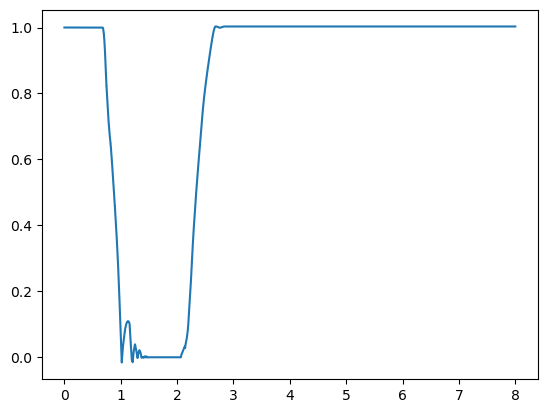

In [ ]:
diagram.SetDefaultContext(context)
plant_context = plant.GetMyContextFromRoot(root_context=simulator.get_context())

q_traj_system.UpdateTrajectory(q_traj)
g_traj_system.UpdateTrajectory(g_traj)

meshcat.StartRecording(set_visualizations_while_recording=False)
simulator.AdvanceTo(6)
velocities = plant.GetVelocities(plant_context)
print (velocities[:7])

simulator.AdvanceTo(6 + time_to_throw)
velocities = plant.GetVelocities(plant_context)
print (velocities[:7])

simulator.AdvanceTo(7)
velocities = plant.GetVelocities(plant_context)
print (velocities[:7])

simulator.AdvanceTo(8)
velocities = plant.GetVelocities(plant_context)
#print (velocities[7:])


log = logger.FindLog(simulator.get_context())
t = log.sample_times()
z = log.data()[7]

print (z.shape)
print ("Height at throw:")
print (z[-1])

plt.plot(t, z)

meshcat.PublishRecording()

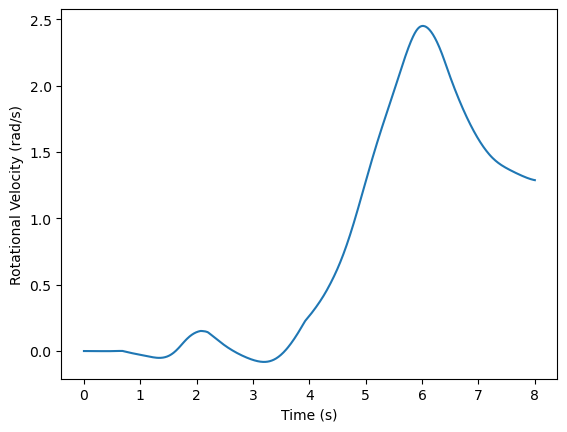

In [ ]:
z = log.data()[0]

plt.figure()
plt.ylabel("Rotational Velocity (rad/s)")
plt.xlabel("Time (s)")
plt.plot(t, z)

In [ ]:
plant.GetVelocityNames()

['iiwa7_iiwa_joint_1_w',
 'iiwa7_iiwa_joint_2_w',
 'iiwa7_iiwa_joint_3_w',
 'iiwa7_iiwa_joint_4_w',
 'iiwa7_iiwa_joint_5_w',
 'iiwa7_iiwa_joint_6_w',
 'iiwa7_iiwa_joint_7_w',
 '003_cracker_box_base_link_cracker_wx',
 '003_cracker_box_base_link_cracker_wy',
 '003_cracker_box_base_link_cracker_wz',
 '003_cracker_box_base_link_cracker_vx',
 '003_cracker_box_base_link_cracker_vy',
 '003_cracker_box_base_link_cracker_vz']

In [ ]:
velocities = plant.GetVelocities(plant_context)
velocities

array([-7.86864466e-02,  1.61502386e-01,  1.73543570e-01,  3.53736985e-01,
       -7.61483034e-01,  6.37139710e-01, -7.33348707e-01,  2.15542313e-02,
       -3.42157271e-02,  1.13796762e-06, -1.12910184e-03, -7.10078573e-04,
        3.45162503e-05])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=118e769b-4a3a-40aa-8d8d-69e00b8c0bfd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>